# Volatility Forecasting FastAPI Application

This notebook shows how to use the Volatility Forecasting FastAPI application.

The first steps to starting the app are:
1. Open a terminal in the location the project files are stored
2. Run this command: 
```python
uvicorn main:app --reload --workers 1 --host localhost --port 8008
```
3. Wait for application to start up and run the following code

## 1 - Imports

In [1]:
%load_ext autoreload
%autoreload 2

import requests
from config import settings
from model import GARCHModel, SQLRepo
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model

C:\Users\abhir\AppData\Local\Programs\Python\Python38\lib\site-packages\pydantic\_internal\_fields.py:127: UserWarning: Field "model_directory" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ('settings_',)`.
  warnings.warn(


## 2 - Using Fast API Application

First step in using the application is to create a SQLite connection, using the `SQLRepo` class from the `model` module

In [2]:
# Create connection in to SQLite
connection = sqlite3.connect(settings.db_name, check_same_thread=False)
repo = SQLRepo(connection=connection)

### 2.1 - Fit Function

After this we call the fit function in the application, using a JSON format specifying the paramaters for:
* `ticker`: The ticker of a specific stock (STRING)
* `use_new_data`: Specifies whether new data is required to be extracted from Alpha Vantage API to SQLite (BOOL)
* `n_obs`: Number of observations to be extracted for the ticker (INT)
* `p`: The autoregressive order for GARCH model (INT)
* `q`: The moving average order for GARCH model (INT)
<br>
<br>
This function will train and save a GARCH model with the specified parameters

In [3]:
# URL for connection to application fit function
url = "http://localhost:8008/fit"

# Parameters for data to be fitted in JSON format
json = {
    "ticker": "IBM",
    "use_new_data": True,
    "n_obs": 2000,
    "p":1,
    "q":1
}

# Check if datatype is dictionary
print(type(json))
# Post request
response = requests.post(url=url, json=json)

print("status code:", response.status_code)
response.json()

<class 'dict'>
status code: 200


{'ticker': 'IBM',
 'use_new_data': True,
 'n_obs': 2000,
 'p': 1,
 'q': 1,
 'success': True,
 'message': "Trained and saved 'models\\2023-09-24T18_23_28.915042_IBM.pkl' - Metrics: AIC 7073.683498679505, BIC 7096.087108517673"}

### 2.2 - Predict Function

The predict function of the app takes the following parameters:
* `ticker`: Ticker of a specific stock (STRING)
* `n_days`: Number of days in future to predict volatility
<br>
<br>
This function will use the model from the `fit` function and use it to predict the volatility for a selected number of days

In [4]:
# URL for connection to application predict function
url = "http://localhost:8008/predict"
# Parameters for data to be predicted in JSON format
json = {"ticker": "IBM", "n_days":5}
# Post request
response = requests.post(url=url, json=json)

print("status code:", response.status_code)
response.json()

status code: 200


{'ticker': 'IBM',
 'n_days': 5,
 'success': True,
 'forecast': {'2023-09-25T00:00:00': 1.3190139414446413,
  '2023-09-26T00:00:00': 1.332963841584773,
  '2023-09-27T00:00:00': 1.3456685894324385,
  '2023-09-28T00:00:00': 1.3572506092067769,
  '2023-09-29T00:00:00': 1.3678182508261967},
 'message': 'Model loaded and prediction generated successfully'}

## 3 - Analysis

In [5]:
# Read table
df_IBM = repo.read_table(table_name="IBM", limit=2000).sort_index(ascending=True)
# Create a column for return based on daily close prices
df_IBM["return"] = df_IBM["close"].pct_change()*100
df_IBM.dropna(inplace=True)

print(df_IBM.head())

# Load existing model from 2.1
garch = GARCHModel(ticker="IBM", repo=repo, use_new_data=False)
garch.load()
model = garch.model

              open    high     low   close      volume    return
date                                                            
2015-10-14  149.60  150.65  149.02  150.01   3352327.0  0.260660
2015-10-15  150.91  151.24  148.58  150.09   3476219.0  0.053330
2015-10-16  150.45  151.20  149.26  150.39   3483599.0  0.199880
2015-10-19  149.85  149.97  148.38  149.22   7954684.0 -0.777977
2015-10-20  142.49  142.88  140.27  140.64  16025591.0 -5.749899


### 3.1 - Conditional Volatility

To assess the validity of the model, we will plot the model's predicted conditional volatility within 2 standard deviations against the stock's returns

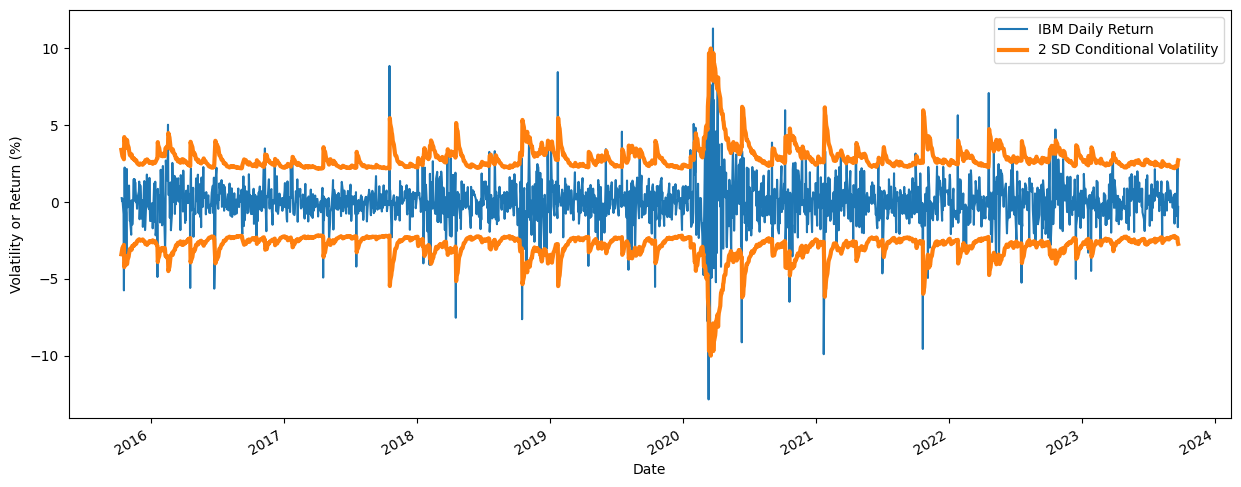

In [6]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns
df_IBM["return"].plot(ax=ax, label="IBM Daily Return")

# Plot conditional volatility within 2 standard deviations
(2 * model.conditional_volatility).plot(ax=ax, color="C1", label="2 SD Conditional Volatility", linewidth=3)
(-2 * model.conditional_volatility.rename("")).plot(ax=ax, color="C1", linewidth=3)

plt.xlabel("Date")
plt.ylabel("Volatility or Return (%)")

plt.legend();

The model appears to predict the volatility of IBM stock well, predicting periods of high volatility relatively accurately.

### 3.2 - Residuals

To further asssess the validity of the model we will look at the residuals. Residuals are the differences betweeen expected and observed values. The residuals should not follow a pattern, as this would indicate model ineffectiveness or model bias.

First we will plot the rediduals with its 180-day rolling average to look for any noticeable trends

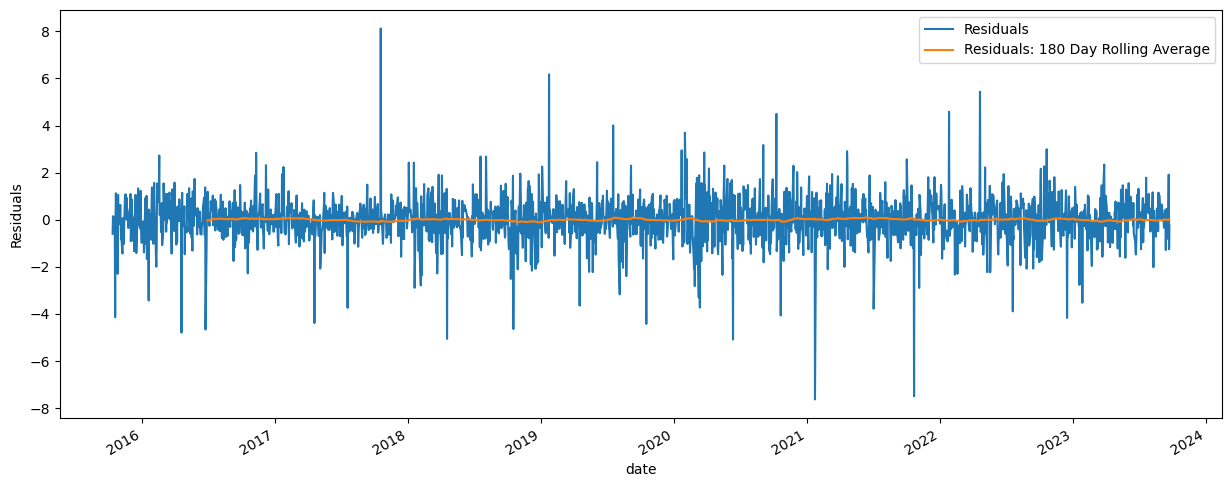

In [7]:
fig, ax = plt.subplots(figsize=(15, 6))

model.std_resid.plot(ax=ax, label="Residuals", xlabel="Date", ylabel="Residuals")
model.std_resid.rolling(180).mean().plot(ax=ax, label="Residuals: 180 Day Rolling Average")

plt.legend();

There does not appear to be a noticeable trend, so we will now look to assess this technically using autocorrelation (ACF) and partial autocorrelation (PACF) plots.

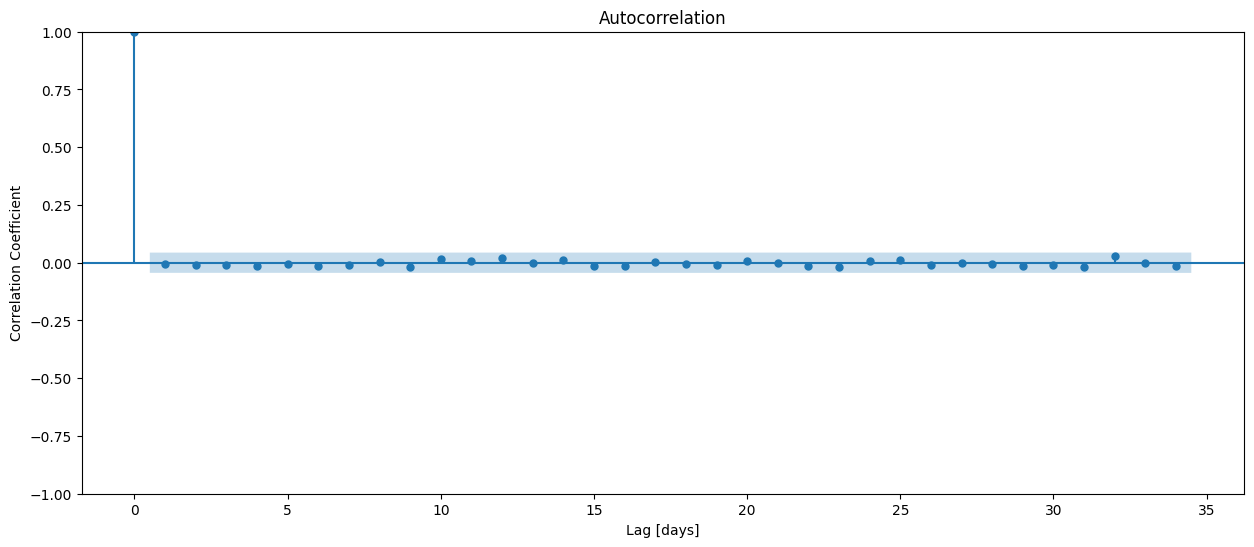

In [8]:
fig, ax = plt.subplots(figsize=(15, 6))

plot_acf(model.std_resid**2, ax=ax)

plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

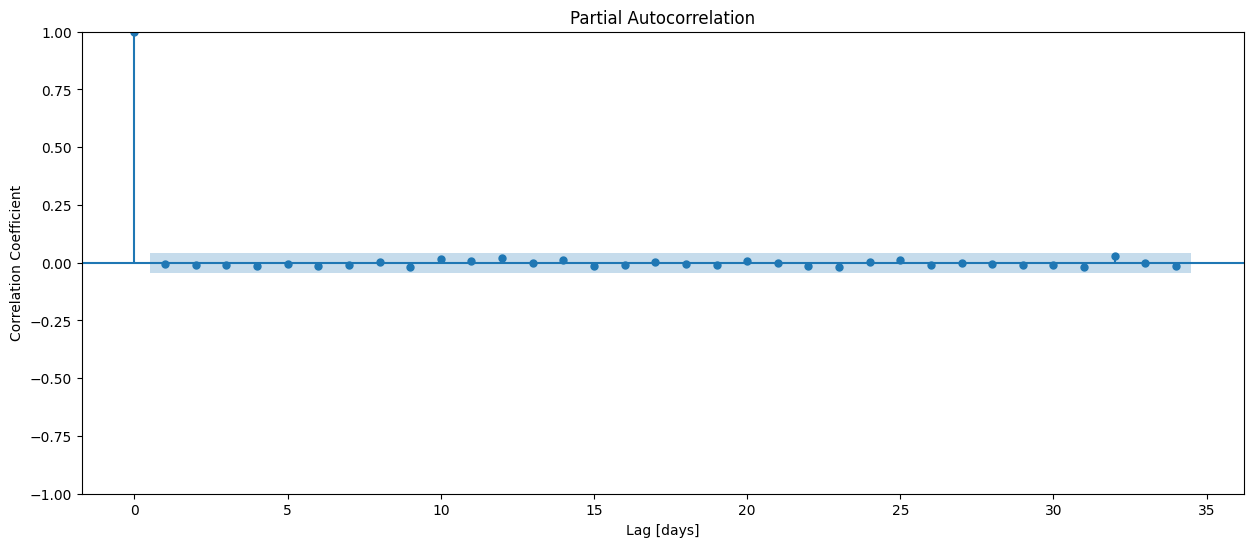

In [9]:
fig, ax = plt.subplots(figsize=(15, 6))

plot_pacf(model.std_resid**2, ax=ax)

plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

The residuals do not appear to follow any trends or be autocorrelated.

### 3.3 - Walk-forward validation

Now we will test the model using walk-forward validation to assess how the model would perform the in a 'real world' scenario

In [10]:
# Extract target
y = df_IBM["return"]

# Create empty list for preidctions
predictions = []

# Select size of test data
test_size = int(len(y) * 0.3)

# Iterate through data upto 'current' date and genrate predictions for following date
for i in range(test_size):
    y_train = y.iloc[: -(test_size - i)]
    model =  arch_model(y_train, p=1, q=1, rescale=False).fit(disp=0)
    next_pred = model.forecast(horizon=1, reindex=False).variance.iloc[0,0]**0.5
    predictions.append(next_pred)

y_test_wfv = pd.Series(predictions, index=y.tail(test_size).index)

y_test_wfv.head()

date
2021-05-07    1.544316
2021-05-10    1.603515
2021-05-11    1.516934
2021-05-12    1.502878
2021-05-13    1.574926
dtype: float64

Next we will plot the predicted volatility (within 2 standard deviations) against the returns of the stock

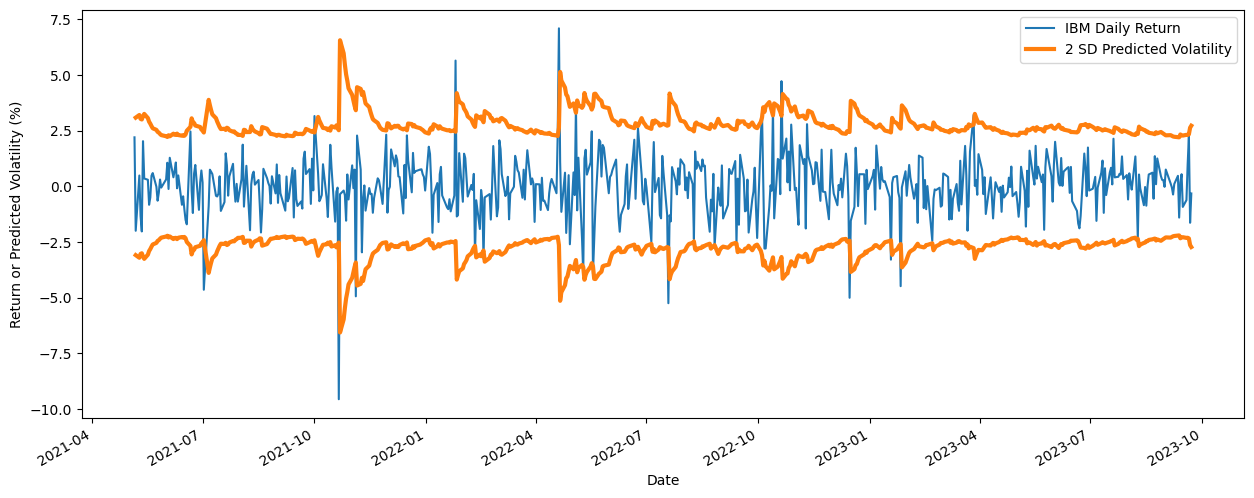

In [11]:
fig, ax = plt.subplots(figsize=(15, 6))
# Plot returns
df_IBM["return"].iloc[int(len(y)*0.7):].plot(ax=ax, label="IBM Daily Return")

# Plot predicted volaitlities 
(2*y_test_wfv).plot(ax=ax, color="C1", label="2 SD Predicted Volatility", linewidth=3)
(-2*y_test_wfv.rename("")).plot(ax=ax, color="C1", linewidth=3)

plt.xlabel("Date")
plt.ylabel("Return or Predicted Volatility (%)")

plt.legend();

The walk-forward validation appears to perform quite well again, capturing the trends in volatility and periods of high volatility.